# Taxi Problem

### Getting Started

Read the description of the environment in subsection 3.1 of [this paper](https://arxiv.org/pdf/cs/9905014.pdf).  You can verify that the description in the paper matches the OpenAI Gym environment by peeking at the code [here](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py).

### Instructions

The repository contains three files:
- `agent.py`: Develop your reinforcement learning agent here.  This is the only file that you should modify.
- `monitor.py`: The `interact` function tests how well your agent learns from interaction with the environment.
- `main.py`: Run this file in the terminal to check the performance of your agent.

When you run `main.py`, the agent that you specify in `agent.py` interacts with the environment for 20,000 episodes.  The details of the interaction are specified in `monitor.py`, which returns two variables: `avg_rewards` and `best_avg_reward`.
- `avg_rewards` is a deque where `avg_rewards[i]` is the average (undiscounted) return collected by the agent from episodes `i+1` to episode `i+100`, inclusive.  So, for instance, `avg_rewards[0]` is the average return collected by the agent over the first 100 episodes.
- `best_avg_reward` is the largest entry in `avg_rewards`.  This is the final score that you should use when determining how well your agent performed in the task.

Your assignment is to modify the `agents.py` file to improve the agent's performance.
- Use the `__init__()` method to define any needed instance variables.  Currently, we define the number of actions available to the agent (`nA`) and initialize the action values (`Q`) to an empty dictionary of arrays.  Feel free to add more instance variables; for example, you may find it useful to define the value of epsilon if the agent uses an epsilon-greedy policy for selecting actions.
- The `select_action()` method accepts the environment state as input and returns the agent's choice of action.  The default code that we have provided randomly selects an action.
- The `step()` method accepts a (`state`, `action`, `reward`, `next_state`) tuple as input, along with the `done` variable, which is `True` if the episode has ended.  The default code (which you should certainly change!) increments the action value of the previous state-action pair by 1.  You should change this method to use the sampled tuple of experience to update the agent's knowledge of the problem.


> Once you have modified the function, you need only run `python main.py` to test your new agent.

### **OpenAI Gym [defines "solving"](https://gym.openai.com/envs/Taxi-v1/) this task as getting average return of 9.7 over 100 consecutive trials.**

In [ ]:
# @title
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
from collections import deque, defaultdict
import gymnasium as gym
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

### Let's explore Taxi Env

* reference link : [gym/taxi](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)

In [ ]:
env = gym.make('Taxi-v3')
state, prob = env.reset()
state, prob

(34, {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)})

In [ ]:
random_policy = np.random.choice(6)
next_state, reward, done, _, prob = env.step(random_policy)
next_state, reward, done

(34, -1, False)

## **Interact** Function from `monitor.py`



In [ ]:
def interact(env, agent, num_episodes=20000, window=100):
    """ Monitor agent's performance.

    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards

    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state, prob = env.reset()
        # initialize the sampled reward
        samp_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state, i_episode)
            # action = agent.select_action(state)
            # agent performs the selected action
            next_state, reward, done, _, prob = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 100):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_rewards),endpoint=False), np.asarray(avg_rewards))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()

    return avg_rewards, best_avg_reward

## Agent class from `agent.py`

In [ ]:
class Agent:

    def __init__(self, nA=6):
        """ Initialize agent.

        Params
        ======
        - nA: number of actions available to the agent
        """

        self.nA = nA

        # self.gamma = 1.0
        self.gamma = 0.99
        # self.alpha = 0.01
        self.alpha = 0.2

        self.Q = defaultdict(lambda: np.zeros(self.nA))

    def select_action(self, state, i_episode):
        """ Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        # epsilon = 0.01
        self.epsilon = (1.0 / i_episode)
        Q_cur = self.Q[state]
        A_s = len(Q_cur)
        greedy_prob = np.ones(A_s) * self.epsilon / A_s
        best_action = np.argmax(Q_cur)
        greedy_prob[best_action] = 1 - self.epsilon + self.epsilon / A_s

        return np.random.choice(np.arange(A_s), p=greedy_prob)

    def step(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """

        if done:
            self.Q[state][action] = self.Q[state][action] + self.alpha * (reward - self.Q[state][action])
        else:
            # Case1. SARSA
            # a_t_1 = self.select_action(next_state)
            # self.Q[state][action] += self.alpha * (reward + self.gamma * self.Q[next_state][a_t_1] - self.Q[state][action])

            # # Case2. Q-learning
            # self.Q[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

            # # Case3. Expected Sarsa
            Q_cur = self.Q[next_state]
            A_s = len(Q_cur)
            greedy_prob = np.ones(A_s) * self.epsilon / A_s
            best_action = np.argmax(Q_cur)
            greedy_prob[best_action] = 1 - self.epsilon + self.epsilon / A_s
            self.Q[state][action] += self.alpha * (reward + self.gamma * np.sum(Q_cur * greedy_prob) - self.Q[state][action])

## Finally, execute **main** code.

Episode 2000/2000 || Best average reward 8.45



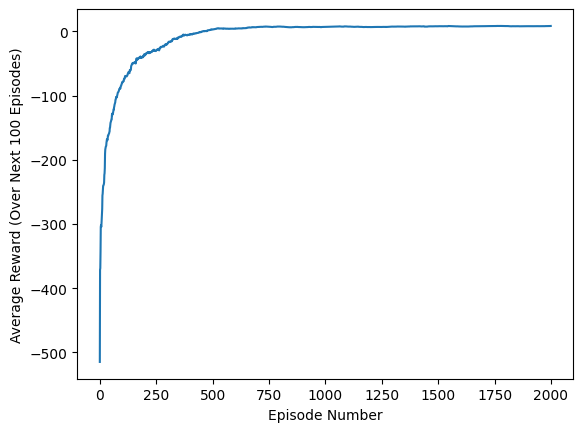

In [ ]:
env = gym.make('Taxi-v3')
agent = Agent()
avg_rewards, best_avg_reward = interact(env, agent, 2000)
# avg_rewards, best_avg_reward = interact(env, agent, 20000)

OpenAI Gym defines "solving" this task as getting average return of 9.7 over 100 consecutive trials.
